1. Gerekli kütüphaneler

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Görselleştirme için ayar
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

2. Veriyi okuma

In [18]:
# Veri dosyasını oku
df = pd.read_csv("survey.csv")

print(f"📌 Veri boyutu: {df.shape[0]} satır, {df.shape[1]} sütun")

# İlk 5 satırı görüntüleyerek genel yapıya göz atalım
df.head()

📌 Veri boyutu: 1259 satır, 27 sütun


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,Male,United States,IN,NaN,No,No,Rarely,More than 1000,...,Dont know,Maybe,No,No,No,No,No,Dont know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Dont know,No,No,Some of them,Yes,Yes,Yes,Dont know,No,NaN


3. Aykırı değer kontrolü ve medyanla temizleme

3. 1. Yaş sütunu temizliği

🎂 Yaş - Minimum: -29, Maksimum: 329
🎯 Medyan yaş: 31.0
⚠️ Düzeltme yapılan aykırı yaş sayısı: 0
✅ Aykırı yaşlar medyan ile değiştirildi.
🎂 Yeni Yaş Aralığı: 15 - 72


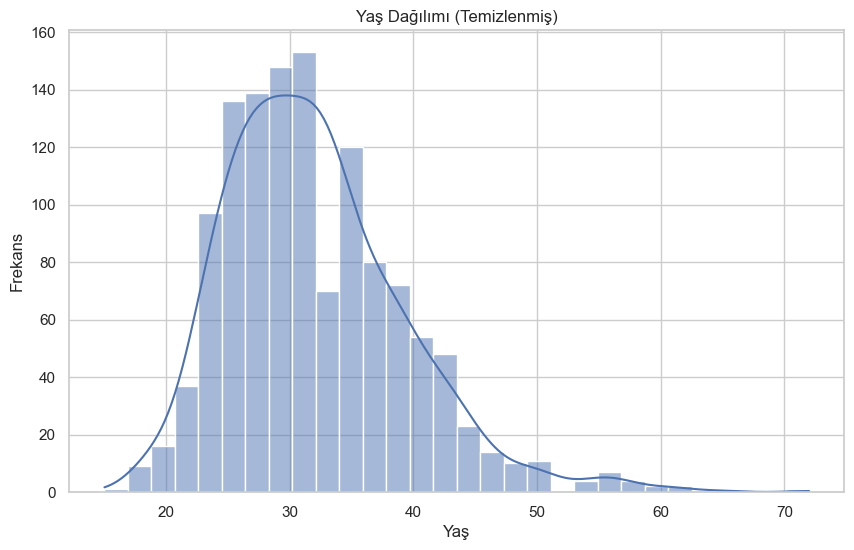

In [19]:
# Yaş sütununu kontrol edelim: 15 yaş altı ve 80 yaş üstü aykırı kabul edilsin
print(f"🎂 Yaş - Minimum: {df['Age'].min()}, Maksimum: {df['Age'].max()}")

# Aykırı yaşları tespit et ve medyan ile değiştir
median_age = df['Age'].median()
df.loc[(df['Age'] < 15) | (df['Age'] > 80), 'Age'] = median_age

print(f"🎯 Medyan yaş: {median_age}")

aykiri_sayisi = ((df['Age'] < 15) | (df['Age'] > 80)).sum()
print(f"⚠️ Düzeltme yapılan aykırı yaş sayısı: {aykiri_sayisi}")

print("✅ Aykırı yaşlar medyan ile değiştirildi.")
print(f"🎂 Yeni Yaş Aralığı: {df['Age'].min()} - {df['Age'].max()}")

sns.histplot(df["Age"], bins=30, kde=True)
plt.title("Yaş Dağılımı (Temizlenmiş)")
plt.xlabel("Yaş")
plt.ylabel("Frekans")
plt.show()

3. 2. Cinsiyet sütunu temizliği

🎭 Orijinal Gender değerleri:
Gender
Male              979
Female            252
Make                4
Male                3
Man                 2
Female              2
Agender             1
Malr                1
Mail                1
Female (cis)        1
queer               1
Female (trans)      1
msle                1
Enby                1
All                 1
Nah                 1
Femake              1
non-binary          1
queer/she/they      1
Male (CIS)          1
Mal                 1
maile               1
femail              1
Name: count, dtype: int64
🗑️ Silinen aykırı cinsiyet sayısı: 0

✅ Temizlenmiş Gender sütunu:
Gender
Male      988
Female    257
Other      14
Name: count, dtype: int64


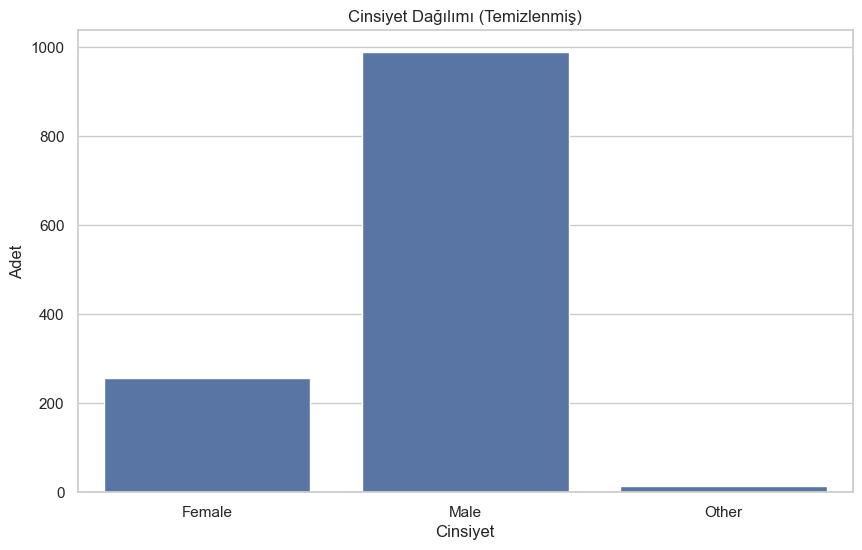

In [20]:
# Gender sütunundaki farklı değerleri görelim
print("🎭 Orijinal Gender değerleri:")
print(df["Gender"].value_counts())

# Fonksiyon: yalnızca Male ve Female ayır, diğerlerini NaN yap
def clean_gender(value):
    value = str(value).strip().lower()
    
    male_terms = ["male", "m", "man","maile", "mal", "msle", "mail"]
    female_terms = ["female", "f", "woman", "female (cis)", "femake", "femail"]
    
    if value in male_terms:
        return "Male"
    elif value in female_terms:
        return "Female"
    else:
        return "Other"  # Ne erkek ne kadın → üçüncü kategori

# Temizleme işlemi
df["Gender"] = df["Gender"].apply(clean_gender)


print(f"🗑️ Silinen aykırı cinsiyet sayısı: {df['Gender'].isna().sum()}")

# Kontrol
print("\n✅ Temizlenmiş Gender sütunu:")
print(df["Gender"].value_counts())

sns.countplot(x="Gender", data=df)
plt.title("Cinsiyet Dağılımı (Temizlenmiş)")
plt.xlabel("Cinsiyet")
plt.ylabel("Adet")
plt.show()

3. 3. Zihinsel sağlık durumunun iş yaşamını ne ölçüde etkilediği sütunu temizliği

🛠 Orijinal 'work_interfere' değerleri:
work_interfere
Sometimes    465
NaN          264
Never        213
Rarely       173
Often        144
Name: count, dtype: int64

✅ Temizlenmiş 'work_interfere' sütunu:
work_interfere
Sometimes    729
Never        213
Rarely       173
Often        144
Name: count, dtype: int64


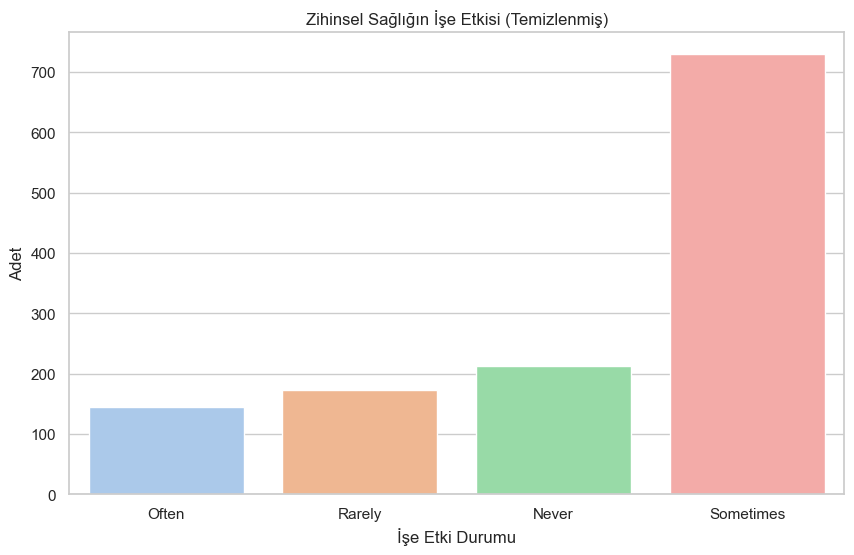

In [21]:
# Geçerli değerler
valid_work_interfere = ["Never", "Rarely", "Sometimes", "Often"]

# 🧐 Orijinal değerleri inceleyelim
print("🛠 Orijinal 'work_interfere' değerleri:")
print(df["work_interfere"].value_counts(dropna=False))

# 🎯 Hem geçersiz hem eksik (NaN) olanları NaN yap
df["work_interfere"] = df["work_interfere"].apply(
    lambda x: x if pd.notna(x) and x in valid_work_interfere else pd.NA
)

# ✅ Eksik olanları en sık geçen (mod) değerle doldur
most_common = df["work_interfere"].mode()[0]
df["work_interfere"] = df["work_interfere"].fillna(most_common)

# 🔍 Son kontrol
print("\n✅ Temizlenmiş 'work_interfere' sütunu:")
print(df["work_interfere"].value_counts())

# 🎨 Görselleştirme: 'work_interfere' sütunu dağılımı
sns.countplot(data=df, x="work_interfere", hue="work_interfere", palette="pastel", legend=False)
plt.title("Zihinsel Sağlığın İşe Etkisi (Temizlenmiş)")
plt.xlabel("İşe Etki Durumu")
plt.ylabel("Adet")
plt.show()

3. 4. Zihinsel sağlık sorunları nedeniyle işten izin almak kolay mı sütunu temizliği

🛠 Orijinal 'leave' değerleri:
leave
Dont know             563
Somewhat easy         266
Very easy             206
Somewhat difficult    126
Very difficult         98
Name: count, dtype: int64

✅ Temizlenmiş 'leave' sütunu:
leave
Somewhat easy         829
Very easy             206
Somewhat difficult    126
Very difficult         98
Name: count, dtype: int64


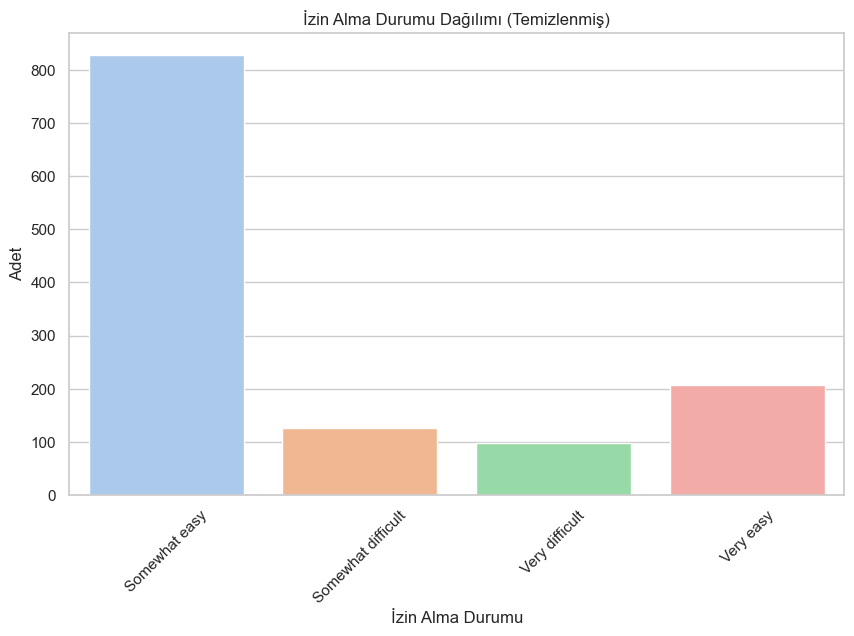

In [22]:
# Geçerli değerler
valid_leave = ["Very difficult", "Somewhat difficult", "Somewhat easy", "Very easy", "Don't know"]

# Mevcut değerleri gözlemleyelim
print("🛠 Orijinal 'leave' değerleri:")
print(df["leave"].value_counts(dropna=False))

# Temizleme işlemi
df["leave"] = df["leave"].where(df["leave"].isin(valid_leave), pd.NA)

# FutureWarning çözümü: inplace=False kullan, sonra atama yap
most_common_leave = df["leave"].mode()[0]
df["leave"] = df["leave"].fillna(most_common_leave)

# Kontrol
print("\n✅ Temizlenmiş 'leave' sütunu:")
print(df["leave"].value_counts())

# 🎨 'leave' Sütununun Dağılım Grafiği
sns.countplot(data=df, x="leave", hue="leave", palette="pastel", legend=False)
plt.title("İzin Alma Durumu Dağılımı (Temizlenmiş)")
plt.xlabel("İzin Alma Durumu")
plt.ylabel("Adet")
plt.xticks(rotation=45)
plt.show()

3. 5. Kişiye fayda sağlayan programlar sunuluyor mu sütunu temizliği

🛠 Orijinal 'benefits' değerleri:
benefits
Yes          477
Dont know    408
No           374
Name: count, dtype: int64

✅ Temizlenmiş 'benefits' değerleri:
benefits
Yes           477
Don't know    408
No            374
Name: count, dtype: int64


/var/folders/dm/hckhrzb5207cp2xy2c6ts38c0000gn/T/ipykernel_5742/592292207.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="benefits", palette="pastel")


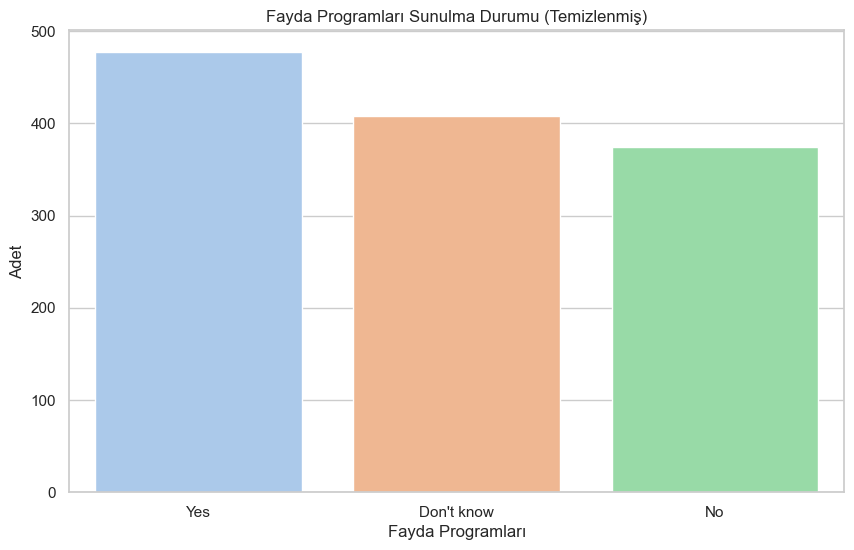

In [23]:
# Geçerli kategoriler
valid_benefits = ["Yes", "No", "Don't know"]

# Orijinal değerleri görelim
print("🛠 Orijinal 'benefits' değerleri:")
print(df["benefits"].value_counts(dropna=False))

# Küçük harfe çevirip boşlukları temizle → sonra uygun kategoriye eşle
def clean_benefits(value):
    if isinstance(value, str):
        value = value.strip().lower()
        if value in ["yes", "ye", "y"]:
            return "Yes"
        elif value in ["no", "n"]:
            return "No"
        elif value in ["dont know", "don't know", "do not know"]:
            return "Don't know"
    return pd.NA

df["benefits"] = df["benefits"].apply(clean_benefits)

# Eksikleri mod ile doldur (mod 3 seçenek arasında kalacak!)
most_common_benefit = df["benefits"].mode()[0]
df["benefits"] = df["benefits"].fillna(most_common_benefit)

# Kontrol
print("\n✅ Temizlenmiş 'benefits' değerleri:")
print(df["benefits"].value_counts())

sns.countplot(data=df, x="benefits", palette="pastel")
plt.title("Fayda Programları Sunulma Durumu (Temizlenmiş)")
plt.xlabel("Fayda Programları")
plt.ylabel("Adet")
plt.show()

3. 6. Zihinsel sağlık için anonim destek alabiliyor mu sütunu temizliği

🛠 Orijinal 'anonymity' değerleri:
anonymity
Dont know    819
Yes          375
No            65
Name: count, dtype: int64

✅ Temizlenmiş 'anonymity' değerleri:
anonymity
Don't know    819
Yes           375
No             65
Name: count, dtype: int64


/var/folders/dm/hckhrzb5207cp2xy2c6ts38c0000gn/T/ipykernel_5742/503178277.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="anonymity", hue=None, palette="pastel")


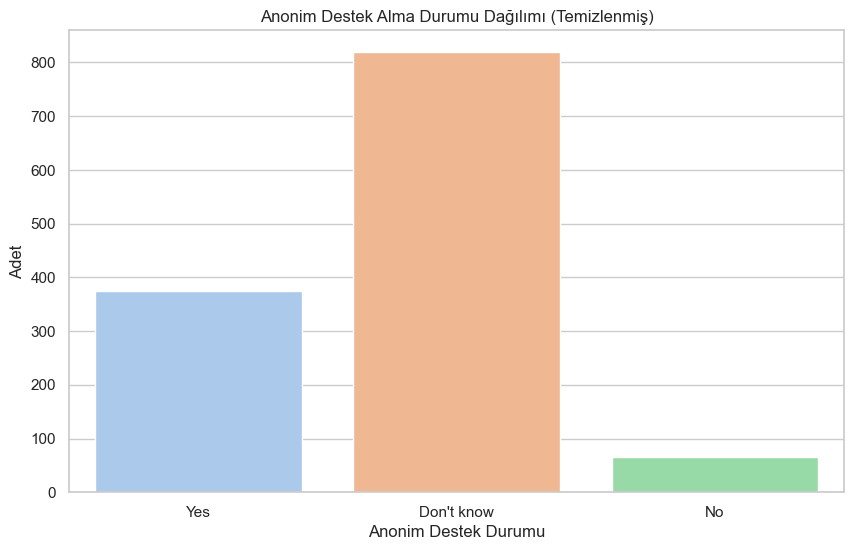

In [24]:
# Geçerli değerler
valid_anonymity = ["Yes", "No", "Don't know"]

# Orijinal değerleri görelim
print("🛠 Orijinal 'anonymity' değerleri:")
print(df["anonymity"].value_counts(dropna=False))

# Küçük harfe çevirip boşlukları temizle → uygun kategoriye eşle
def clean_anonymity(value):
    if isinstance(value, str):
        value = value.strip().lower().replace("’", "'").replace("‘", "'")  # farkları da yakala!
        if value in ["yes", "ye", "y"]:
            return "Yes"
        elif value in ["no", "n"]:
            return "No"
        elif value in ["dont know", "don't know", "do not know"]:
            return "Don't know"
    return pd.NA

# Temizleme işlemi
df["anonymity"] = df["anonymity"].apply(clean_anonymity)

# Eksikleri "Don't know" ile doldur
df["anonymity"] = df["anonymity"].fillna("Don't know")

# Kontrol
print("\n✅ Temizlenmiş 'anonymity' değerleri:")
print(df["anonymity"].value_counts())

# 🎨 Görselleştirme (uyarısız hali)
sns.countplot(data=df, x="anonymity", hue=None, palette="pastel")
plt.title("Anonim Destek Alma Durumu Dağılımı (Temizlenmiş)")
plt.xlabel("Anonim Destek Durumu")
plt.ylabel("Adet")
plt.show()

4. Veri temizliği

🧹 Temizlik sonrası veri şekli: (1259, 23)
🧹 Kalan sütunlar: ['Age', 'Gender', 'Country', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']

✅ Eksik değer bulunmuyor.


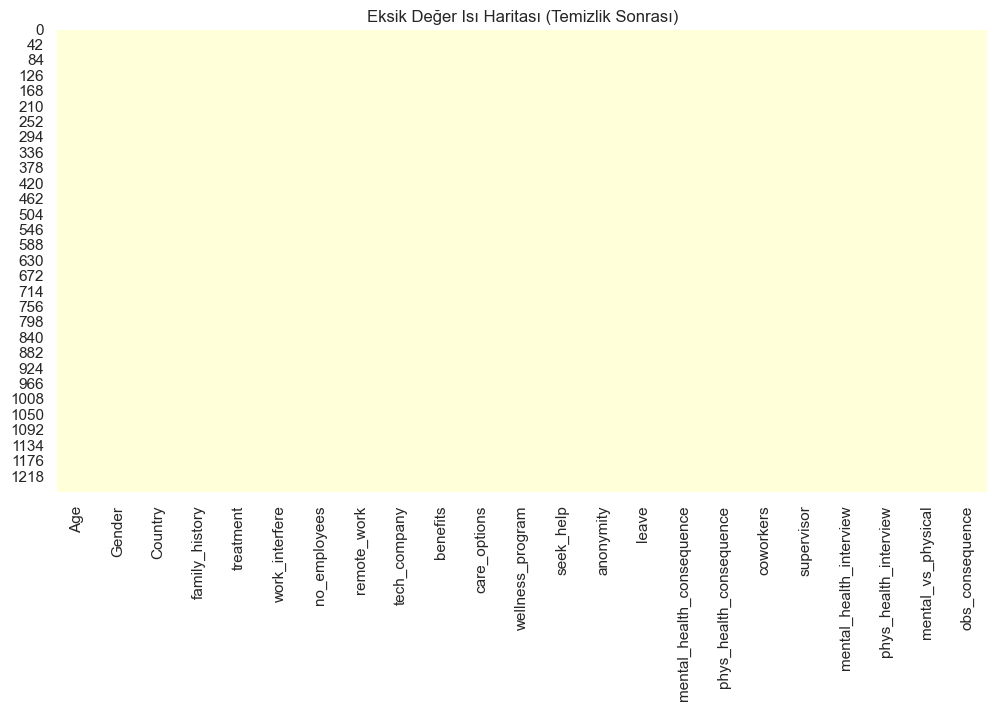

In [25]:
# 1️⃣ Gereksiz sütunları temizle
gereksiz_sutunlar = ["Timestamp", "self_employed", "comments", "state"]
df.drop(columns=gereksiz_sutunlar, inplace=True, errors="ignore")

# 2️⃣ Geçersiz yaşları filtrele
df = df[(df["Age"] >= 15) & (df["Age"] <= 80)]

# 3️⃣ Temizlik sonrası kontrol
print(f"🧹 Temizlik sonrası veri şekli: {df.shape}")
print(f"🧹 Kalan sütunlar: {df.columns.tolist()}")

# 4️⃣ Eksik değer kontrolü 🔎
missing = df.isnull().sum()
missing = missing[missing > 0]  # Sadece eksik olanları göster
if not missing.empty:
    print("\n⚠️ Eksik değer içeren sütunlar:")
    print(missing)
else:
    print("\n✅ Eksik değer bulunmuyor.")

# 🎨 6️⃣ Eksik değer oranları (Isı haritası ile)
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu")
plt.title("Eksik Değer Isı Haritası (Temizlik Sonrası)")
plt.show()

5. Encoding

support_needed
0    660
1    599
Name: count, dtype: int64


/var/folders/dm/hckhrzb5207cp2xy2c6ts38c0000gn/T/ipykernel_5742/2205768421.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="support_needed", palette="pastel")


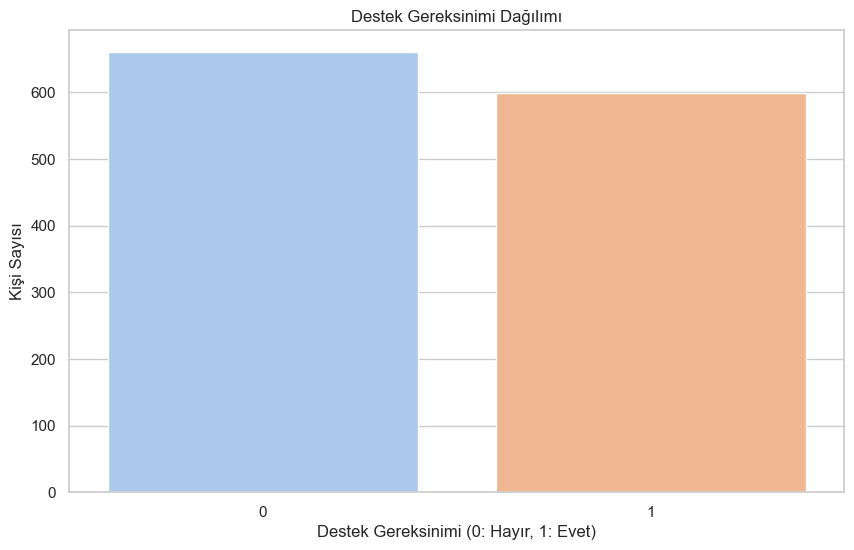

In [26]:
# ✅ Risk eşiği
RISK_THRESHOLD = 3  # Riskli kabul edilme eşiği

# ✅ Risk faktörleri ve puanları
risk_factors = {
    'family_history': {'Yes': 1},
    'work_interfere': {'Often': 1, 'Sometimes': 1},
    'supervisor': {'No': 1},
    'coworkers': {'No': 1},
    'care_options': {'No': 1},
    'benefits': {'No': 1},
    'anonymity': {'No': 1},
}

# ✅ Geliştirilmiş support_needed fonksiyonu
def calculate_support_needed(row):
    risk_score = 0

    # Psikolojik risk faktörlerini değerlendirme
    for col, risk_dict in risk_factors.items():
        if row[col] in risk_dict:
            risk_score += risk_dict[row[col]]

    # Ek kriter: Küçük ölçekli işyerinde bakım seçeneği yoksa
    if row['no_employees'] in ['1-5', '6-25'] and row['care_options'] == 'No':
        risk_score += 1

    # Risk skoru eşik kontrolü
    return 1 if risk_score >= RISK_THRESHOLD else 0

# Fonksiyonu uygulama
df['support_needed'] = df.apply(calculate_support_needed, axis=1)

# Sonuçları gösterme
print(df['support_needed'].value_counts())

# Görselleştirme
sns.countplot(data=df, x="support_needed", palette="pastel")
plt.title("Destek Gereksinimi Dağılımı")
plt.xlabel("Destek Gereksinimi (0: Hayır, 1: Evet)")
plt.ylabel("Kişi Sayısı")
plt.show()

6. Kategorik Sütunlar için encoding

6.1. Metinsel ifadelerin saklanması - react için gerekli

In [27]:
# Kategorik sütunlar
categorical_cols = [
    'Gender', 'Country', 'family_history', 'treatment', 'work_interfere', 'no_employees',
    'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program',
    'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence',
    'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
    'mental_vs_physical', 'obs_consequence'
]

# Orijinal metinsel değerleri saklamak için sözlük
original_values_dict = {}

# 🔁 Metinsel değerleri saklama
for col in categorical_cols:
    # Veriyi önce string formatına zorla
    df[col] = df[col].astype(str).fillna("Unknown")
    
    # Özel durum: "No" her zaman 0, "Yes" her zaman 1 olmalı
    if col in ['benefits', 'wellness_program', 'seek_help', 'anonymity']:
        # Sıralama: No -> Yes -> Diğer
        original_values = sorted(df[col].unique().tolist(), key=lambda x: (x != "No", x != "Yes", x))
    else:
        # Alfabetik sıralama
        original_values = sorted(df[col].unique().tolist())

    # Orijinal değerleri kaydet
    original_values_dict[col] = original_values
    print(f"🔍 {col} sütunu orijinal değerler: {original_values}")

# Orijinal değerleri kaydetme
encoder_cat_path = "../deployment/mental_encoder_cat.pkl"
try:
    joblib.dump(original_values_dict, encoder_cat_path)
    print(f"\n✅ Orijinal metinsel değerler başarıyla kaydedildi: '{encoder_cat_path}'")
except Exception as e:
    print(f"❌ Orijinal metinsel değerler kaydedilemedi: {str(e)}")

🔍 Gender sütunu orijinal değerler: ['Female', 'Male', 'Other']
🔍 Country sütunu orijinal değerler: ['Australia', 'Austria', 'Bahamas, The', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
🔍 family_history sütunu orijinal değerler: ['No', 'Yes']
🔍 treatment sütunu orijinal değerler: ['No', 'Yes']
🔍 work_interfere sütunu orijinal değerler: ['Never', 'Often', 'Rarely', 'Sometimes']
🔍 no_employees sütunu orijinal değerler: ['1-5', '100-500', '26-100', '500-1000', '6-25', 'More than 1000']
🔍 remote_work süt

6.2. metinsel değerlerin sayısala dönüştürülmesi ve saklanması

In [28]:
# Encoder'ları saklamak için sözlük
encoders = {}

# Orijinal metinsel değerleri yükleme
try:
    original_values_dict = joblib.load("../deployment/mental_encoder_cat.pkl")
    print(f"✅ Orijinal metinsel değerler başarıyla yüklendi: '../deployment/mental_encoder_cat.pkl'\n")
except Exception as e:
    print(f"❌ Orijinal metinsel değerler yüklenemedi: {str(e)}")

# 🔁 Encode işlemi
for col in categorical_cols:
    le = LabelEncoder()

    try:
        # Orijinal sıralamayı al (eğer yoksa alfabetik sıraya göre yap)
        original_values = original_values_dict.get(col, None)
        if original_values is None:
            original_values = sorted(df[col].unique().tolist())
            print(f"⚠️ {col} sütunu için orijinal değerler bulunamadı, alfabetik sıralama yapıldı.")
        
        # LabelEncoder'a orijinal sıralamayı öğret
        le.fit(original_values)

        # Encode işlemi
        df[col] = le.transform(df[col])

        # Encoder nesnesini kaydetme
        encoders[col] = le

        # Encode edilmiş değerleri yazdırma
        unique_vals = sorted(df[col].unique().tolist())
        print(f"✅ {col} sütunu başarıyla encode edildi. Değerler: {unique_vals}")
    except Exception as e:
        print(f"🚫 Hata: {col} sütunu encode edilemedi. {str(e)}")

# Encoder'ları kaydetme
encoder_path = "../deployment/mental_encoders.pkl"
try:
    joblib.dump(encoders, encoder_path)
    print(f"\n✅ Encoder'lar başarıyla kaydedildi: '{encoder_path}'")
except Exception as e:
    print(f"❌ Encoder kaydedilemedi: {str(e)}")

✅ Orijinal metinsel değerler başarıyla yüklendi: '../deployment/mental_encoder_cat.pkl'

✅ Gender sütunu başarıyla encode edildi. Değerler: [0, 1, 2]
✅ Country sütunu başarıyla encode edildi. Değerler: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
✅ family_history sütunu başarıyla encode edildi. Değerler: [0, 1]
✅ treatment sütunu başarıyla encode edildi. Değerler: [0, 1]
✅ work_interfere sütunu başarıyla encode edildi. Değerler: [0, 1, 2, 3]
✅ no_employees sütunu başarıyla encode edildi. Değerler: [0, 1, 2, 3, 4, 5]
✅ remote_work sütunu başarıyla encode edildi. Değerler: [0, 1]
✅ tech_company sütunu başarıyla encode edildi. Değerler: [0, 1]
✅ benefits sütunu başarıyla encode edildi. Değerler: [0, 1, 2]
✅ care_options sütunu başarıyla encode edildi. Değerler: [0, 1, 2]
✅ wellness_program sütunu başarıyla encode edildi. Değerler: [0, 1, 2]
✅ seek_help 

7. Train ve test olarak ayırma

In [29]:
# Bağımlı ve bağımsız değişkenleri belirle
X = df.drop("support_needed", axis=1)  # 'support_needed' hedef sütunu
y = df["support_needed"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Eğitim ve test verisindeki sınıf dağılımını kontrol et
print("✅ Eğitim verisi şekli:", X_train.shape)
print("✅ Test verisi şekli:", X_test.shape)

# Sınıf dağılımını göster
print("\n🔍 Eğitim Verisi Sınıf Dağılımı:")
print(y_train.value_counts(normalize=True).round(3))

print("\n🔍 Test Verisi Sınıf Dağılımı:")
print(y_test.value_counts(normalize=True).round(3))

✅ Eğitim verisi şekli: (1007, 23)
✅ Test verisi şekli: (252, 23)

🔍 Eğitim Verisi Sınıf Dağılımı:
support_needed
0    0.524
1    0.476
Name: proportion, dtype: float64

🔍 Test Verisi Sınıf Dağılımı:
support_needed
0    0.524
1    0.476
Name: proportion, dtype: float64


8. Train ve Test ön işlenmiş verilerin kaydı

In [30]:
# 🔍 Eğitim ve test verisini kaydetme (ön işleme sonrası)
train_df = pd.DataFrame(X_train, columns=X.columns)
train_df["support_needed"] = y_train

test_df = pd.DataFrame(X_test, columns=X.columns)
test_df["support_needed"] = y_test

# 💾 Veriyi kaydetme
os.makedirs("normal", exist_ok=True)
train_df.to_csv("normal/train_mental.csv", index=False)
test_df.to_csv("normal/test_mental.csv", index=False)

print("✅ Veriler başarıyla kaydedildi: 'normal/train_mental.csv', 'normal/test_mental.csv'")

✅ Veriler başarıyla kaydedildi: 'normal/train_mental.csv', 'normal/test_mental.csv'


8. Ölçeklendirme (StandartScaler)

In [31]:
# # 🔢 Sayısal ve kategorik sütunları ayır
# numeric_cols = ['Age']
# categorical_cols = [col for col in X_train.columns if col not in numeric_cols and col != 'support_needed']

# # 🌟 Ayrı ayrı scaler tanımla
# scaler_num = StandardScaler()

# # 🌟 Sayısal verileri ölçekleme
# X_train_num_scaled = scaler_num.fit_transform(X_train[numeric_cols])
# X_test_num_scaled = scaler_num.transform(X_test[numeric_cols])

# # 🌟 Kategorik verileri ölçekleme
# X_train_cat_scaled = X_train[categorical_cols].copy()
# X_test_cat_scaled = X_test[categorical_cols].copy()

# # 🔀 Verileri birleştirme (ölçeklenmiş sayısal ve encode edilmiş kategorik)
# X_train_scaled = pd.concat(
#     [pd.DataFrame(X_train_num_scaled, columns=numeric_cols).reset_index(drop=True), X_train_cat_scaled.reset_index(drop=True)],
#     axis=1
# )

# X_test_scaled = pd.concat(
#     [pd.DataFrame(X_test_num_scaled, columns=numeric_cols).reset_index(drop=True), X_test_cat_scaled.reset_index(drop=True)],
#     axis=1
# )

# # ✅ Kontrol
# print("✅ Ölçeklenmiş Eğitim Verisi:", X_train_scaled.shape)
# print("✅ Ölçeklenmiş Test Verisi:", X_test_scaled.shape)

# # 💾 Scaler ve encoder'ları tek bir dosyada kaydet
# scalers = {'num': scaler_num}
# joblib.dump(scalers, "../deployment/mental_scalers.pkl")
# print("💾 Scaler'lar tek dosyada kaydedildi: '../deployment/mental_scalers.pkl'")

9. Encoder Sözlüğü kaydı

In [32]:
# # 💾 Encoder sözlüğünü kaydetme (ülke isimlerini içerecek şekilde)
# encoder_path = "../deployment/mental_encoders.pkl"
# country_map_path = "../deployment/country_map.pkl"

# try:
#     # Encoder'ları kaydet
#     joblib.dump(encoders, encoder_path)
#     print(f"✅ Encoder'lar başarıyla kaydedildi: '{encoder_path}'")

#     # Ülke isimleri ve sayısal değerlerini kaydetme
#     if 'Country' in encoders:
#         country_map = dict(zip(encoders['Country'].classes_, range(len(encoders['Country'].classes_))))
#         joblib.dump(country_map, country_map_path)
#         print(f"✅ Ülke isimleri ve kodları kaydedildi: '{country_map_path}'")
#     else:
#         print("❌ 'Country' encoders içinde bulunamadı.")
# except FileNotFoundError:
#     print(f"❌ Dosya bulunamadı: '{encoder_path}' - Lütfen yolu kontrol edin.")
# except PermissionError:
#     print(f"🚫 İzin hatası: '{encoder_path}' - Yazma izniniz olup olmadığını kontrol edin.")
# except Exception as e:
#     print(f"⚠️ Beklenmeyen hata: {str(e)}")